<a href="https://colab.research.google.com/github/YoheiFukuhara/nlp100-2020/blob/main/09.RNN%2CCNN/87_%E7%A2%BA%E7%8E%87%E7%9A%84%E5%8B%BE%E9%85%8D%E9%99%8D%E4%B8%8B%E6%B3%95%E3%81%AB%E3%82%88%E3%82%8BCNN%E3%81%AE%E5%AD%A6%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [ ]:
import numpy as np
import nltk
from gensim.models import KeyedVectors
import pandas as pd
import tensorflow as tf
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python --version
!pip show numpy gensim google tensorflow nltk pandas

Python 3.7.12
Name: numpy
Version: 1.19.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: yellowbrick, xgboost, xarray, wordcloud, torchvision, torchtext, tifffile, thinc, Theano-PyMC, tensorflow, tensorflow-probability, tensorflow-hub, tensorflow-datasets, tensorboard, tables, statsmodels, spacy, sklearn-pandas, seaborn, scs, scipy, scikit-learn, scikit-image, resampy, qdldl, PyWavelets, python-louvain, pystan, pysndfile, pymc3, pyerfa, pyemd, pyarrow, plotnine, patsy, pandas, osqp, opt-einsum, opencv-python, opencv-contrib-python, numexpr, numba, nibabel, netCDF4, moviepy, mlxtend, mizani, missingno, matplotlib, matplotlib-venn, lightgbm, librosa, Keras-Preprocessing, kapre, jpeg4py, jaxlib, jax, imgaug, imbalanced-learn, imageio, hyperopt, holoviews, h5py, gym, gensim, folium, fix-yahoo-

In [ ]:
%%time
BASE_PATH = '/content/drive/MyDrive/ColabNotebooks/ML/NLP100_2020/'
max_len = 0
vocabulary = []
w2v_model = KeyedVectors.load_word2vec_format(BASE_PATH+'07.WordVector/input/GoogleNews-vectors-negative300.bin.gz', binary=True)

CPU times: user 2min 20s, sys: 6.04 s, total: 2min 26s
Wall time: 2min 30s


In [ ]:
def read_dataset(type_):
    global max_len
    global vocabulary
    df = pd.read_table(BASE_PATH+'06.MachineLearning/'+type_+'.feature.txt')
    df.info()
    sr_title = df['title'].str.split().explode()
    max_len_ = df['title'].map(lambda x: len(x.split())).max()
    if max_len < max_len_:
        max_len = max_len_
    if len(vocabulary) == 0:
        vocabulary = [k for k, v in nltk.FreqDist(sr_title).items() if v > 1]
    else:
        vocabulary.extend([k for k, v in nltk.FreqDist(sr_title).items() if v > 1])
    y = df['category'].replace({'b':0, 't':1, 'e':2, 'm':3})
    return df['title'], tf.keras.utils.to_categorical(y, dtype='int32')  # 4値分類なので訓練・検証・テスト共通でone-hot化

In [ ]:
X_train, y_train = read_dataset('train')
X_valid, y_valid = read_dataset('valid')
X_test, y_test = read_dataset('test') # あまりこだわらずにテストデータセットも追加

# setで重複削除し、タプル形式に設定
tup_voc = tuple(set(vocabulary))

print(f'vocabulary size before removing duplicates: {len(vocabulary)}')
print(f'vocabulary size after removing duplicates: {len(tup_voc)}')
print(f'sample vocabulary: {tup_voc[:10]}')
print(f'max length is {max_len}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10684 entries, 0 to 10683
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     10684 non-null  object
 1   category  10684 non-null  object
dtypes: object(2)
memory usage: 167.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     1336 non-null   object
 1   category  1336 non-null   object
dtypes: object(2)
memory usage: 21.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     1336 non-null   object
 1   category  1336 non-null   object
dtypes: object(2)
memory usage: 21.0+ KB
vocabulary size before removing duplicates: 11089
vocabulary size after removing duplicates: 7802
sa

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(
 output_mode='int',
 vocabulary=tup_voc,
 output_sequence_length=max_len)

print(f'vocabulary size is {vectorize_layer.vocabulary_size()}')

vocabulary size is 7804


In [ ]:
%%time
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((vectorize_layer.vocabulary_size(), embedding_dim))
for i, word in enumerate(vectorize_layer.get_vocabulary()):
    try:
        embedding_matrix[i] = w2v_model.get_vector(word)
        hits += 1
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
    except:
        misses += 1
        if misses < 7:  # Show 6 words as example
            print(word)


[UNK]
axe
mende
at&t
eia
CPU times: user 49.2 ms, sys: 10.1 ms, total: 59.3 ms
Wall time: 72.9 ms


In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    vectorize_layer.vocabulary_size(),
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False
)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(embedding_layer)
model.add(tf.keras.layers.Reshape((max_len * embedding_dim, 1)))
model.add(tf.keras.layers.Conv1D(filters=8, 
                                 kernel_size=embedding_dim*3, 
                                 padding='same',
                                 strides=embedding_dim,
                                 activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 18)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 18, 300)           2341200   
                                                                 
 reshape_11 (Reshape)        (None, 5400, 1)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 18, 8)             7208      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 9, 8)             0         
 1D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 72)              

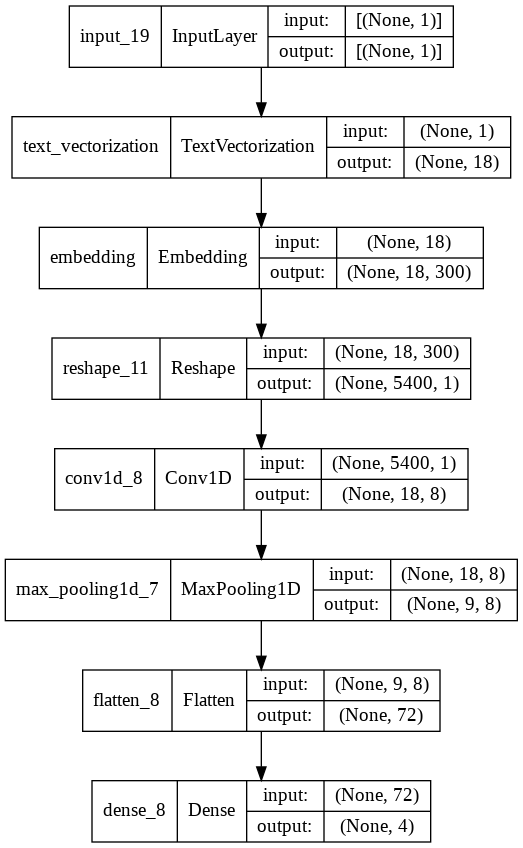

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
%%time
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid),
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=False)])

Epoch 1/100
334/334 [==============================] - 4s 9ms/step - loss: 1.1798 - acc: 0.5131 - val_loss: 1.0692 - val_acc: 0.6729
Epoch 2/100
334/334 [==============================] - 3s 8ms/step - loss: 0.9628 - acc: 0.7381 - val_loss: 0.8597 - val_acc: 0.7515
Epoch 3/100
334/334 [==============================] - 3s 8ms/step - loss: 0.7901 - acc: 0.7471 - val_loss: 0.7428 - val_acc: 0.7530
Epoch 4/100
334/334 [==============================] - 3s 8ms/step - loss: 0.7038 - acc: 0.7547 - val_loss: 0.6838 - val_acc: 0.7545
Epoch 5/100
334/334 [==============================] - 3s 8ms/step - loss: 0.6527 - acc: 0.7601 - val_loss: 0.6468 - val_acc: 0.7620
Epoch 6/100
334/334 [==============================] - 3s 8ms/step - loss: 0.6141 - acc: 0.7704 - val_loss: 0.6182 - val_acc: 0.7650
Epoch 7/100
334/334 [==============================] - 3s 8ms/step - loss: 0.5812 - acc: 0.7839 - val_loss: 0.5946 - val_acc: 0.7792
Epoch 8/100
334/334 [==============================] - 3s 8ms/step - 

In [ ]:
model.evaluate(X_test, y_test)

42/42 [==============================] - 0s 7ms/step - loss: 0.4202 - acc: 0.8608


[0.4201797544956207, 0.8607784509658813]